**CONNECT TO DRIVE AND LOAD THE DATASETS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/blood/data.zip

Archive:  /content/drive/MyDrive/blood/data.zip
replace data/test/A+/cluster_0_1001.BMP? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**COLOR PALATTE**

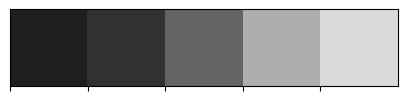

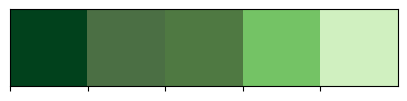

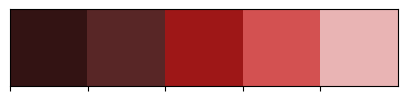

In [1]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

**DATA PREPERATION**

In [ ]:
labels = ['A+','A-','AB+','AB-','B+','B-','O+','O-']

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/data','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/data','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 320/320 [00:00<00:00, 3457.83it/s]


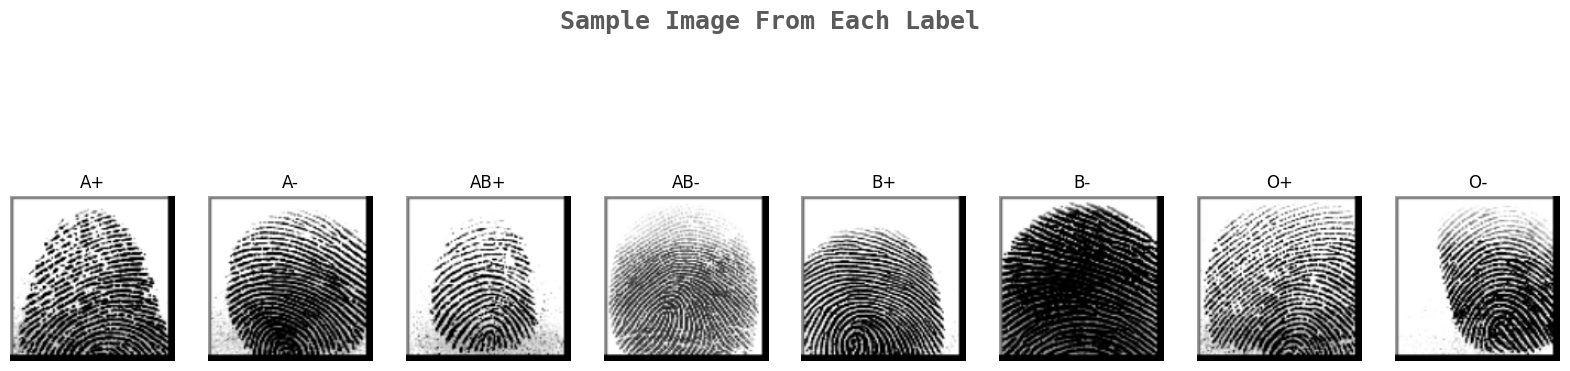

In [ ]:
import matplotlib.pyplot as plt
k=0
fig, ax = plt.subplots(1,8,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(8990, 150, 150, 3)

**Dividing the dataset into Training and Testing sets. bold text bold text**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(8091, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
print(labels)


['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [ ]:
import tensorflow as tf

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Transfer Learning

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(8,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 4,017,796 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6510 - loss: 0.9347
Epoch 1: val_accuracy improved from -inf to 0.80384, saving model to effnet.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 910s 4s/step - accuracy: 0.6515 - loss: 0.9333 - val_accuracy: 0.8038 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8704 - loss: 0.3446
Epoch 2: val_accuracy improved from 0.80384 to 0.86557, saving model to effnet.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 851s 4s/step - accuracy: 0.8704 - loss: 0.3445 - val_accuracy: 0.8656 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9064 - loss: 0.2548
Epoch 3: val_accuracy improved from 0.86557 to 0.87106, saving model to effnet.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 845s 4s/step - accuracy: 0.9064 - loss: 0.2547 - val_accuracy: 0.8711 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9198 - loss: 0.2181
Epoch 4: val_accuracy improved from 0.87106 to 0.91770, saving model to effnet.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.9198 - loss: 0.2181 - val_accuracy: 0.9177 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9478 - loss: 0.1334
Epoch 5: val_accuracy improved from 0.91770 to 0.92867, saving model to effnet.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 888s 4s/step - accuracy: 0.9478 - loss: 0.1334 - val_accuracy: 0.9287 - val_loss: 0.1933 - learning_rate: 0.0010


# Training The Model

In [ ]:
from warnings import filterwarnings

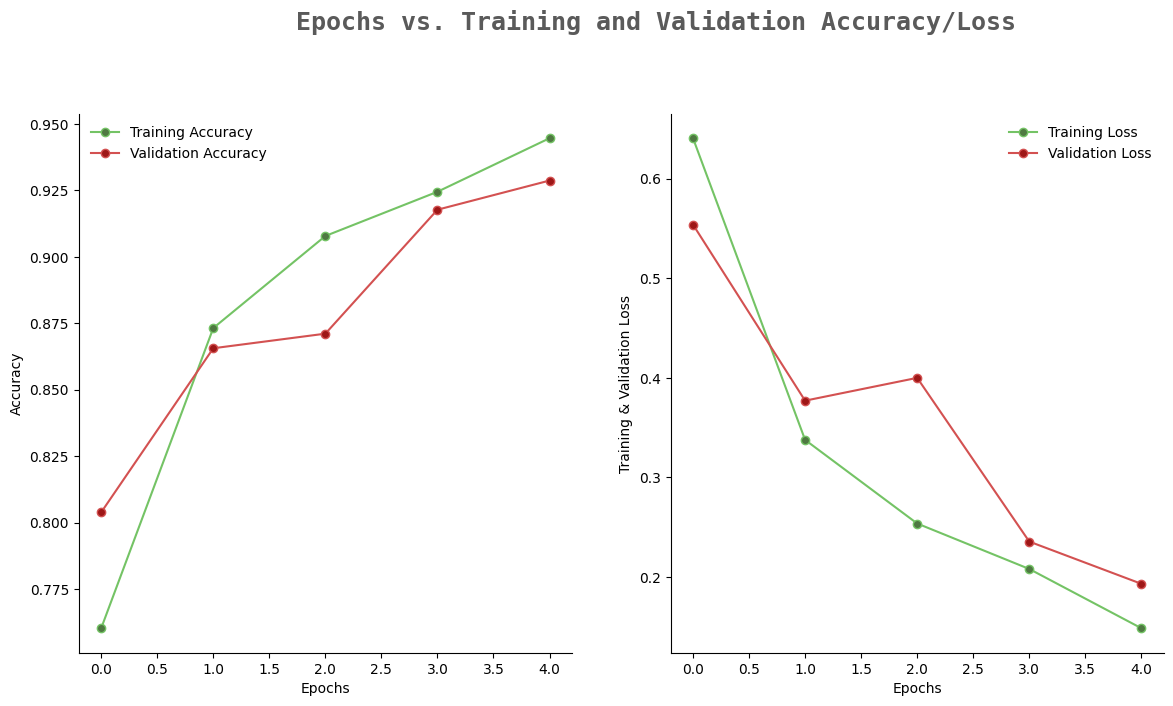

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Prediction

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


# Evaluation

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95        90
           1       0.90      0.94      0.92       127
           2       0.93      0.98      0.95       106
           3       0.98      0.80      0.88       106
           4       0.96      0.93      0.94       101
           5       0.85      1.00      0.92        88
           6       0.98      0.88      0.92        98
           7       0.85      0.95      0.89        94

    accuracy                           0.92       810
   macro avg       0.93      0.92      0.92       810
weighted avg       0.93      0.92      0.92       810



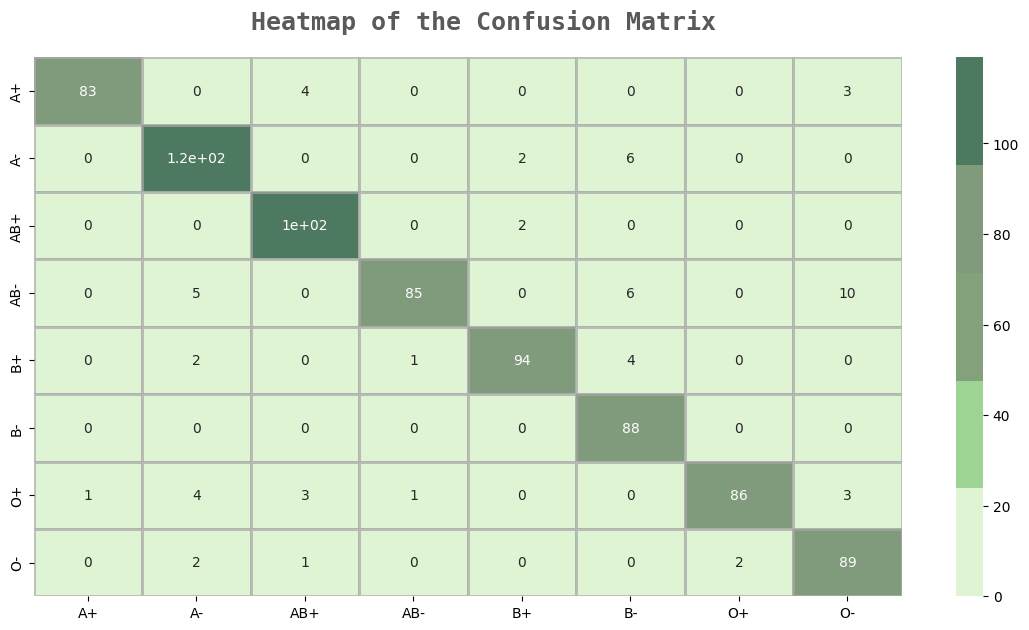

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    # Assuming 'uploader' is a widget containing the uploaded file
    for name, file_info in upload.value.items():
        # Open the image
        img = Image.open(io.BytesIO(file_info['content']))
        # Convert to OpenCV format
        opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        # Resize the image to 150x150
        img_resized = cv2.resize(opencv_image, (150, 150))
        # Reshape the image to match the input shape expected by the model
        img_reshaped = img_resized.reshape(1, 150, 150, 3)

        # Predict the class
        predictions = model.predict(img_reshaped)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index

        # Define the labels for the 8 classes
        labels = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

        # Get the corresponding label for the predicted class
        predicted_label = labels[predicted_class]

        # Print the result
        print(f"The model predicts the blood type as: {predicted_label}")


**UPLOAD THE FINGERPRINT IMAGES AND TEST THE DATA**

In [ ]:
import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

# Button for prediction
button = widgets.Button(description='Predict', button_style='success')  # Add some style
out = widgets.Output()

# Define the callback function for the button
def on_button_clicked(_):
    with out:
        clear_output()  # Clear previous outputs
        try:
            # Call the prediction function
            img_pred(uploader)
        except Exception as e:
            # Handle errors gracefully
            print('No Image Uploaded or Invalid Image File')
            print(f"Error: {str(e)}")

# Attach the callback function to the button
button.on_click(on_button_clicked)

# Display the button and output area in a vertical layout
display(widgets.VBox([button, out]))


In [ ]:
import io
import cv2
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import clear_output, display

# File upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

# Recommendations based on blood groups
def get_recommendations(blood_group):
    recommendations = {
        "A+": {"Fruits": ["Berries", "Apples"], "Vegetables": ["Spinach", "Carrots"], "Exercise": ["Yoga", "Meditation"]},
        "A-": {"Fruits": ["Oranges", "Pineapple"], "Vegetables": ["Celery", "Zucchini"], "Exercise": ["Walking", "Tai Chi"]},
        "B+": {"Fruits": ["Bananas", "Papaya"], "Vegetables": ["Broccoli", "Eggplant"], "Exercise": ["Swimming", "Cycling"]},
        "B-": {"Fruits": ["Grapes", "Pineapple"], "Vegetables": ["Cabbage", "Beets"], "Exercise": ["Hiking", "Dancing"]},
        "AB+": {"Fruits": ["Figs", "Watermelon"], "Vegetables": ["Cauliflower", "Kale"], "Exercise": ["Light jogging", "Yoga"]},
        "AB-": {"Fruits": ["Cherries", "Kiwi"], "Vegetables": ["Cucumber", "Spinach"], "Exercise": ["Stretching", "Walking"]},
        "O+": {"Fruits": ["Mango", "Bananas"], "Vegetables": ["Broccoli", "Peppers"], "Exercise": ["Running", "Weightlifting"]},
        "O-": {"Fruits": ["Plums", "Avocado"], "Vegetables": ["Kale", "Tomatoes"], "Exercise": ["Aerobics", "HIIT"]}
    }
    return recommendations.get(blood_group, {"Fruits": [], "Vegetables": [], "Exercise": []})

# Prediction function
def img_pred(upload):
    try:
        for name, file_info in upload.value.items():
            # Process uploaded image
            img = Image.open(io.BytesIO(file_info['content']))
            opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            img_resized = cv2.resize(opencv_image, (150, 150))
            img_reshaped = img_resized.reshape(1, 150, 150, 3)

            # Predict the class
            predictions = model.predict(img_reshaped)
            predicted_class = np.argmax(predictions, axis=1)[0]

            # Blood group labels
            labels = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
            predicted_blood_group = labels[predicted_class]
            print(f"The model predicts the blood type as: {predicted_blood_group}")

            # Get recommendations
            rec = get_recommendations(predicted_blood_group)
            print("\nRecommendations:")
            print(f"  Fruits: {', '.join(rec['Fruits'])}")
            print(f"  Vegetables: {', '.join(rec['Vegetables'])}")
            print(f"  Exercise: {', '.join(rec['Exercise'])}")
    except Exception as e:
        print("No Image Uploaded or Invalid Image File")
        print(f"Error: {e}")

# Predict button
button = widgets.Button(description='Predict', button_style='success')
out = widgets.Output()

# Button callback
def on_button_clicked(_):
    with out:
        clear_output()
        img_pred(uploader)

button.on_click(on_button_clicked)

# Display button and output
display(widgets.VBox([button, out]))


FileUpload(value={}, accept='image/*', description='Upload')